# Final Project: House Prices - Advanced Regression Techniques

In [1]:
#Load all the necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load the data
training_dataset_path = "/Users/ritikaakailas/Desktop/house-prices-advanced-regression-techniques/train.csv"
testing_dataset_path = "/Users/ritikaakailas/Desktop/house-prices-advanced-regression-techniques/test.csv"
train_data = pd.read_csv(training_dataset_path)
test_data = pd.read_csv(testing_dataset_path)

# Performing Exploratory Data analysis(EDA)

In [3]:
print("The first five rows of the dataset are as follows:")
print(train_data.head())

print("\n Information about the dataset")
print(train_data.info())

print("\n Summary statistics:")
print(train_data.describe())

print("\n Check for missing values")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values>0])

The first five rows of the dataset are as follows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleTyp

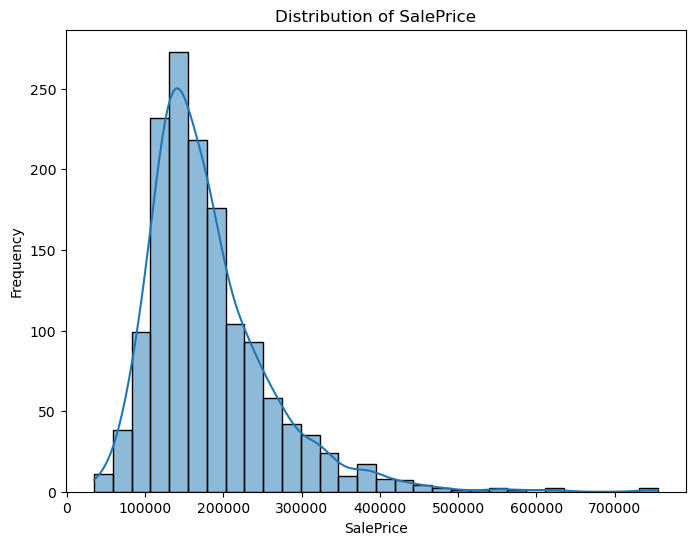

In [4]:
#Visualize the target variable(SalePrice)
plt.figure(figsize = (8,6))
sns.histplot(train_data["SalePrice"], kde = True, bins = 30)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

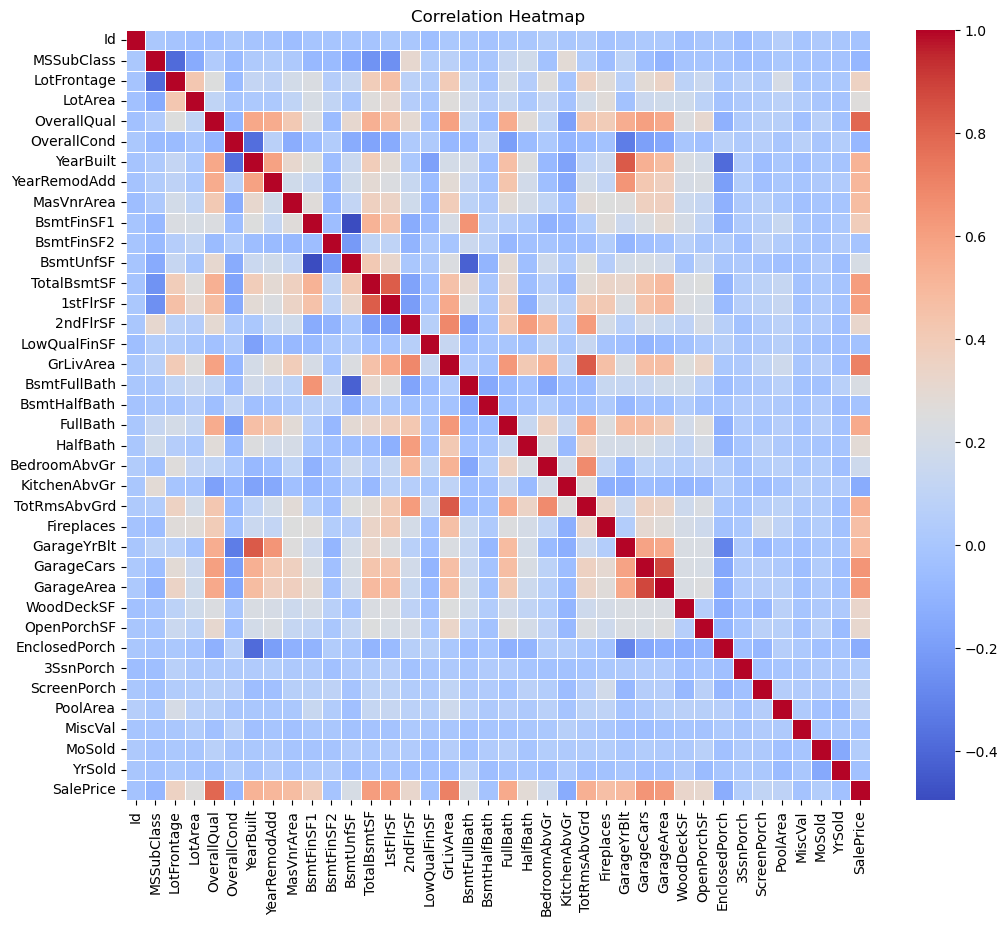

In [5]:
#Correlation heatmap for numeric variables; Select only numeric columns for correlation
numeric_training_data = train_data.select_dtypes(include=["number"])
corr_matrix = numeric_training_data.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr_matrix, annot = False, cmap = "coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
#Features highly correlated with SalesPrice
correlated_features = corr_matrix["SalePrice"].sort_values(ascending = False)
print("\nFeatures most correlated to SalePrice are:")
print(correlated_features.head(10))


Features most correlated to SalePrice are:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


# Defining the preprocessing function

In [7]:
def preprocess_data(data, train_columns = None, fill_strategy="median"):
    #Fill the missing values for the numerical features
    if fill_strategy == "median":
        data["LotFrontage"] = data["LotFrontage"].fillna(data["LotFrontage"].median())
        data["GarageYrBlt"] = data["GarageYrBlt"].fillna(data["GarageYrBlt"].median())
    elif fill_strategy == "mean":
        data["LotFrontage"] = data["LotFrontage"].fillna(data["LotFrontage"].mean())
        data["GarageYrBlt"] = data["GarageYrBlt"].fillna(data["GarageYrBlt"].mean())
    
    data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
    
    #Fill the missing values for categorical features
    for col in ["Alley", "FireplaceQu", "PoolQC", "MiscFeature", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtQual","BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]:
        data[col] = data[col].fillna("None")

    #Fill electrical with mode
    if "Electrical" in data.columns:
        data["Electrical"] = data["Electrical"].fillna(data["Electrical"].mode()[0])

    # Performed one-hot encoding for categorical features
    data = pd.get_dummies(data, drop_first=True)

    # Align columns with training data
    if train_columns is not None:
        data = data.reindex(columns=train_columns, fill_value=0)

    return data

# Preprocessing the training data

In [8]:
train_data = preprocess_data(train_data)
train_columns = train_data.columns

#Applying Log transform to the target variable (as mentioned in kaggle)
train_data["SalePrice"] = np.log(train_data["SalePrice"])

#Performing feature and target selection
target = "SalePrice"
X = train_data.drop(columns = ["Id", target])
y = train_data[target]

# Preprocessing the testing data

In [9]:
test_data_preprocessed = preprocess_data(test_data, train_columns=train_columns)

# Selecting features for test data
test_X = test_data_preprocessed[X.columns]

# Checking for missing values in test_X
print("Checking for missing values in test_X...")
if test_X.isnull().sum().sum() > 0:
    print("Missing values found in test_X filling them with median...")
    test_X = test_X.fillna(test_X.median())
else:
    print("No missing values found in test_X!")

Checking for missing values in test_X...
Missing values found in test_X filling them with median...


# Model Training

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Function to evaluate the model with different hyperparameters
def evaluate_gb_model(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf):
    gb_model = GradientBoostingRegressor(
        random_state = 42,
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf
    )
    # Training the model
    gb_model.fit(X_train, y_train)
    # Prediction on validation set
    y_pred_gb = gb_model.predict(X_valid)
    # Calculating RMSE
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_gb))
    print(f"RMSE with n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}: {rmse}")
    return rmse

# Improving Model Prediction

In [12]:
# Testing with different hyperparameter combinations
results = []
for n_estimators in [100, 200, 300]:
    for learning_rate in [0.01, 0.1, 0.2]:
        for max_depth in [3, 4, 5]:
            for min_samples_split in [5, 10]:
                for min_samples_leaf in [3, 5]:
                    rmse = evaluate_gb_model(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf)
                    results.append((n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf, rmse))


RMSE with n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=5, min_samples_leaf=3: 0.2556033351459909
RMSE with n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=5, min_samples_leaf=5: 0.25564096525384794
RMSE with n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=10, min_samples_leaf=3: 0.2556033351459909
RMSE with n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=10, min_samples_leaf=5: 0.25564096525384794
RMSE with n_estimators=100, learning_rate=0.01, max_depth=4, min_samples_split=5, min_samples_leaf=3: 0.24056745677469984
RMSE with n_estimators=100, learning_rate=0.01, max_depth=4, min_samples_split=5, min_samples_leaf=5: 0.2412227508033113
RMSE with n_estimators=100, learning_rate=0.01, max_depth=4, min_samples_split=10, min_samples_leaf=3: 0.2404280086734111
RMSE with n_estimators=100, learning_rate=0.01, max_depth=4, min_samples_split=10, min_samples_leaf=5: 0.2412227508033113
RMSE with n_estimators=10

In [13]:
# Storing the best combination
results = sorted(results, key=lambda x: x[5])  # Sorting by RMSE
print("\nBest Parameters:")
print(f"n_estimators = {results[0][0]}, learning_rate = {results[0][1]}, max_depth = {results[0][2]}, "
      f"min_samples_split = {results[0][3]}, min_samples_leaf = {results[0][4]}, RMSE = {results[0][5]}")


Best Parameters:
n_estimators = 300, learning_rate = 0.1, max_depth = 3, min_samples_split = 10, min_samples_leaf = 3, RMSE = 0.13307325582908314


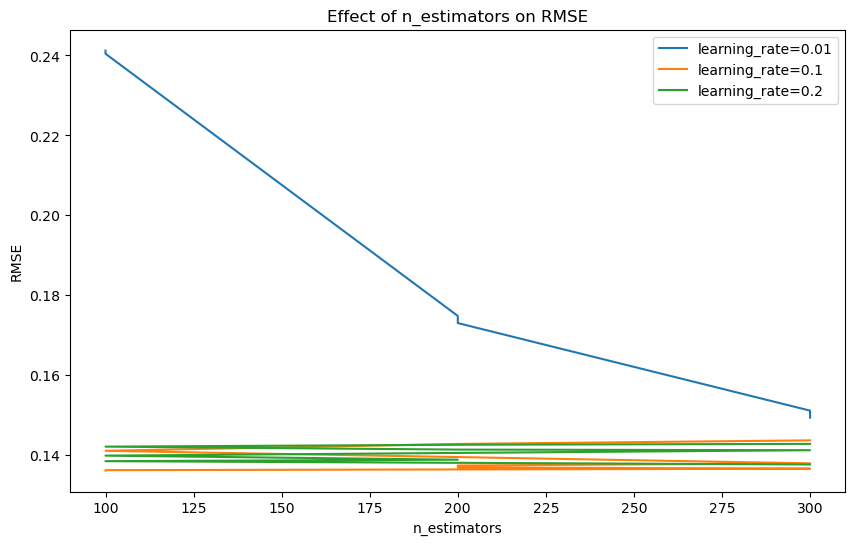

In [14]:
results_df = pd.DataFrame(results, columns=["n_estimators", "learning_rate", "max_depth", "min_samples_split", "min_samples_leaf", "rmse"])

# Plot: RMSE vs. n_estimators for a fixed learning_rate and max_depth
plt.figure(figsize=(10, 6))
for learning_rate in [0.01, 0.1, 0.2]:
    subset = results_df[(results_df["learning_rate"] == learning_rate) & (results_df["max_depth"] == 4)]
    plt.plot(subset["n_estimators"], subset["rmse"], label=f"learning_rate={learning_rate}")

plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title("Effect of n_estimators on RMSE")
plt.legend()
plt.show()


# Training the final model with the best parameters and using it for prediction

In [15]:
#Using the best parameters from tuning
best_params = results[0]
gb_model_best = GradientBoostingRegressor(
    random_state=42,
    n_estimators=best_params[0],       
    learning_rate=best_params[1],    
    max_depth=best_params[2], 
    min_samples_split=best_params[3], 
    min_samples_leaf=best_params[4] 
)

# Training the model
gb_model_best.fit(X_train, y_train)

# Making predictions on the testset
test_predictions_best = np.exp(gb_model_best.predict(test_X))

# Creating the submission file (as required by kaggle)
submission = pd.DataFrame({"Id": test_data["Id"], "SalePrice": test_predictions_best})
submission_file_path = "submission_best.csv"
submission.to_csv(submission_file_path, index=False)
print(f"Submission file created at: {submission_file_path}\n")

print("Contents of the submission file:")
print(submission.to_string(index=False))

Submission file created at: submission_best.csv

Contents of the submission file:
  Id     SalePrice
1461 128620.392722
1462 161789.816152
1463 178898.127823
1464 188156.080170
1465 197014.078628
1466 179434.935845
1467 181720.555109
1468 169992.226853
1469 183737.764260
1470 123047.737285
1471 202327.789200
1472  90357.458055
1473  94349.579764
1474 149197.393582
1475 129342.846876
1476 398621.472221
1477 275834.441634
1478 284780.366691
1479 246027.125293
1480 490617.610156
1481 328486.050213
1482 204140.378835
1483 160194.861205
1484 162382.353729
1485 178403.995905
1486 190253.040895
1487 370745.422666
1488 242831.928719
1489 214951.020390
1490 215723.342859
1491 195487.523439
1492  94884.523189
1493 194785.745377
1494 300180.006685
1495 292656.501797
1496 223442.718719
1497 176069.376998
1498 151747.221154
1499 153062.110188
1500 136520.560179
1501 169431.313494
1502 135880.974180
1503 295034.791803
1504 234560.940933
1505 213822.185136
1506 188848.125050
1507 252500.429160
1508 1